In [1]:
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [383]:
def opti_steps(m_l=0.5, tau_max=0.05, omega_max=3000, nsteps=3, t=0.004, X_init=[0,0,0], T_guess=[0.0003, 5], k_guess=3000):
    ''' Optimize T1 and T2 over multiple steps '''

    ''' Function for one analytical step '''
   
    k = SX.sym('k')
    X0 = SX.sym('X0', 5) #states: x_a, x_l, v_l, T1_last, T2_last
    x_a0 = X0[0]
    x_l0 = X0[1]
    v_l0 = X0[2]
    T1_0 = X0[3]
    T2_0 = X0[4]
    T = SX.sym('T', 2) #transmission ratio for this step
    T1 = T[0]
    T2 = T[1]
    x_l0 = T2*(x_a0*(T1-T1_0) + x_l0/T2_0) #solve for x_l to make spring compression continuous

    x0 = 1/T2
    x1 = T2**2
    x2 = omega_max**2
    x3 = x1*x2
    x4 = k**2
    x5 = m_l**2
    x6 = T1**4*x5
    x7 = x4*x6
    x9 = 1/tau_max
    x10 = (1/2)*x9
    x12 = T1**2
    x13 = omega_max*t
    x14 = k*x10*x12*x13
    x15 = exp(x14)
    x16 = tau_max*x15
    x17 = x16*x_a0
    x18 = T1*omega_max
    x19 = T2*m_l*v_l0*x18
    x20 = m_l*x12
    x21 = x20*x3
    x22 = k*m_l
    x23 = 2*tau_max
    x24 = x23*x_l0
    x25 = x12*x22
    x26 = x23*x_a0
    x27 = T2*omega_max
    x28 = T2**3
    x29 = omega_max**3
    x30 = T1**3
    x32 = exp(-x14)
    x33 = x32*x9
    x34 = x1*x18
    x35 = T2*v_l0 - x34
    x36 = 2*k
    x37 = T1*T2
    x38 = omega_max*x1
    x39 = 2*v_l0*x25*x38
    x40 = x2*x28
    x41 = x22*x30*x40
    x42 = 2*x41
    x43 = tau_max*x36
    x44 = -x37*x43*x_a0 + x43*x_l0
    r = 4*k*m_l*tau_max**2 - x3*x7
    R_ad_re = if_else(r>0, sqrt(r), 0)
    R_ad_im = if_else(r>0, 0, sqrt(-r))
    x11_re = t*x0*x10*R_ad_re/m_l
    x11_im = t*x0*x10*R_ad_im/m_l
    C_os = cos(x11_re)*cosh(x11_im)
    S_in_re = sin(x11_re)*cosh(x11_im)
    S_in_im = cos(x11_re)*sinh(x11_im)
    SdR = (S_in_re*R_ad_re + S_in_im*R_ad_im) / (R_ad_re**2 + R_ad_im**2) # S_in/R_ad should be purely real (aka x31)
    SmR = S_in_re*R_ad_re - S_in_im*R_ad_im  # S_in*R_ad should be purely real
    x_a = x33*(C_os*(-x19 + x21) + x13*x16 + x15*x19 - x15*x21 + x17 + SdR*(-k*v_l0*x3*x30*x5 + k*x28*x29*x6 + x18*x22*x24 - x25*x26*x27))
    x_l = (1/2)*x33*(C_os*(-x39 + x42 + x44) + SmR*x35 + T2*t*x16*x18*x36 + x15*x39 - x15*x42 + x17*x36*x37 + SdR*(T1**5*T2**4*x29*x4*x5 - m_l*x26*x30*x38*x4 - v_l0*x40*x7 + x20*x24*x27*x4))/k
    v_l = x0*x32*(C_os*x35 + x15*x34 + SdR*(k*m_l*omega_max*v_l0*x1*x12 - x41 - x44))
    X_new = SX.sym('X_new', 5)
    X_new[0] = x_a
    X_new[1] = x_l
    X_new[2] = v_l
    X_new[3] = T1
    X_new[4] = T2

    Fstep = Function("step", [X0, T, k], [X_new])
    Fstep_n = Fstep.mapaccum(nsteps)


    ''' Optimization '''
    opti = Opti()

    Ts = opti.variable(2, nsteps) #column vectors of [T1, T2], concat horizontally
    k_var = opti.variable() #column vectors of [T1, T2], concat horizontally
    X_n = Fstep_n(np.concatenate((X_init, T_guess)), Ts, k_var)

    opti.minimize(-X_n[2,-1])
    # opti.set_initial(Ts[0,:], T_guess[0])
    # opti.set_initial(Ts[1,:], T_guess[1])

    opti.set_initial(Ts[0,:], np.random.uniform(low=1e-6, high=0.001, size=nsteps))
    opti.set_initial(Ts[1,:], np.random.uniform(low=1e-6, high=20, size=nsteps))
    opti.set_initial(k_var, k_guess)

    opti.subject_to(opti.bounded(1e-6, Ts[0,:], 0.002))
    opti.subject_to(opti.bounded(1e-6, Ts[1,:], 100))
    # for i in range(nsteps-1):
    #     opti.subject_to(opti.bounded(-0.0001, Ts[0,i+1] - Ts[0,i], 0.0001))
    #     opti.subject_to(opti.bounded(-3, Ts[1,i+1] - Ts[1,i], 3))
    opti.subject_to(sum2(X_n[2,:])*t < 0.1) #limit the maximum leg extension using the integral of leg vel (sum across t)
    opti.subject_to(X_n[2,:] >= 0) #leg vel cannot be negative
    opti.subject_to(opti.bounded(10, k_var, 10000))

    log = []
    opti.callback(lambda i: log.append(opti.debug.value(X_n)))

    opts = {'ipopt.print_level':0, 'print_time':0}
    opti.solver('ipopt', opts)
    sol = opti.solve()
    k_opt = sol.value(k_var)

    # end_x = sol.value(sum2(X_n[2,:])*t)

    return sol, np.array(log), k_opt

1374.2221874801978


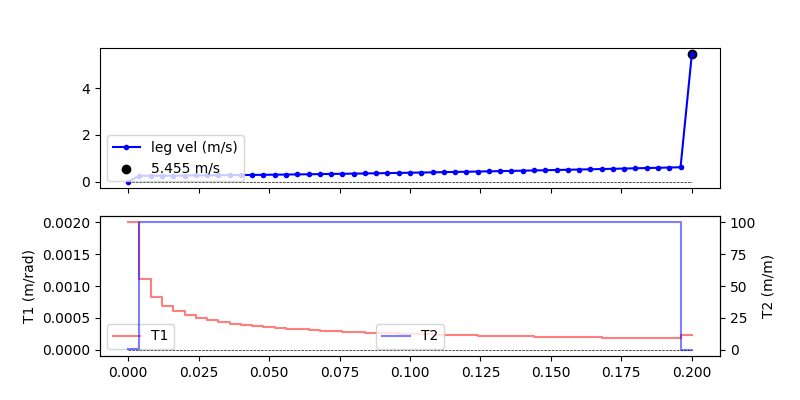

In [390]:
m_l=0.5
tau_max=0.05
omega_max=3000
t_total = 0.2
nsteps = 50
t = t_total/nsteps #should be named dt

sol, log, k_opt = opti_steps(m_l=m_l, tau_max=tau_max, omega_max=omega_max, nsteps=nsteps, t=t, X_init=[0,0,0], k_guess=100)

X_opt = np.insert(log[-1], 0, [0,0,0,log[-1,3,0],log[-1,4,0]], axis=1)
ts = np.linspace(0, t_total, nsteps+1)
x_as = X_opt[0,:]
v_as = np.gradient(x_as, ts)
x_ls_adj = X_opt[1,:]
v_ls = X_opt[2,:]
x_ls = np.cumsum(v_ls) * t
T1s = X_opt[3,:]
T2s = X_opt[4,:]

KE = (1/2)*m_l*v_ls**2
PE = (1/2)*k_opt*(x_as*T1s - x_ls_adj/T2s)**2
motor_powers = tau_max*v_as*(1 - v_as/omega_max)
E_motor = np.cumsum(motor_powers) * t

plt.close('all')
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8,4))
ts = np.linspace(0, t_total, nsteps+1)

# axs[0].set_title(f"Optimal transmission ratios, {nsteps} steps over {round(t_total, 2)} sec. \n m_l={m_l}, k={round(k_opt)}")

# axs[0].plot(ts, v_as, 'b.-', label='motor vel (rad/s)')
# axs[0].plot(ts, np.full(ts.shape, omega_max/2), 'g--', linewidth=0.5)

# axs[1].plot(ts, x_ls, 'r.-', label='leg pos (m)')
# # axs[1].plot(ts, x_ls_adj, 'r.-', label='leg pos adj (m)')

axs[0].plot(ts, v_ls, 'b.-', label='leg vel (m/s)')
axs[0].scatter(ts[-1], v_ls[-1], c='black', label=f"{round(v_ls[-1],3)} m/s")

# axs[3].plot(ts, KE, label='Kinetic')
# axs[3].plot(ts, PE, label='Potential')
# axs[3].plot(ts, KE+PE, label='Total')
# axs[3].plot(ts, E_motor, label='Motor')

axs[1].step(ts, T1s, label='T1', color='red', alpha=0.5)
axs[1].set_ylabel('T1 (m/rad)')
axs_twin = axs[1].twinx()
axs_twin.step(ts, T2s, label='T2', color='blue', alpha=0.5)
axs_twin.set_ylabel('T2 (m/m)')
axs_twin.legend()

print(k_opt)

# axs[5].plot(ts, motor_powers, 'y-', label='motor power (W)')

for ax in axs:
    ax.plot(ts, np.zeros_like(ts), 'k--', linewidth=0.5)
    ax.legend(loc='lower left')
plt.show()

1374.2221874801978


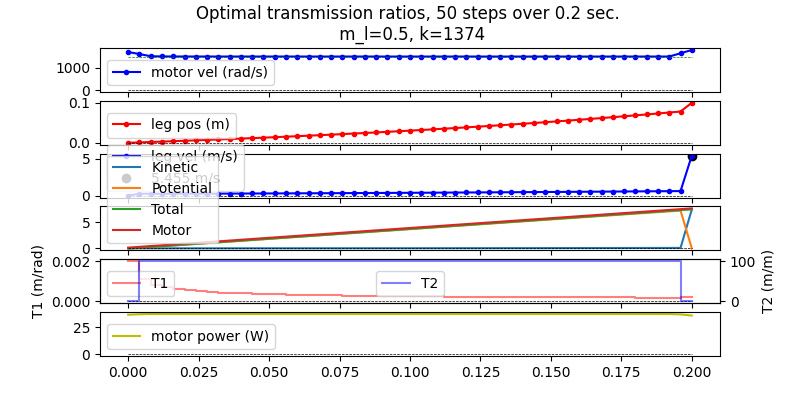

In [392]:
fig, axs = plt.subplots(6, 1, sharex=True, figsize=(8,4))
ts = np.linspace(0, t_total, nsteps+1)

axs[0].set_title(f"Optimal transmission ratios, {nsteps} steps over {round(t_total, 2)} sec. \n m_l={m_l}, k={round(k_opt)}")

axs[0].plot(ts, v_as, 'b.-', label='motor vel (rad/s)')
axs[0].plot(ts, np.full(ts.shape, omega_max/2), 'g--', linewidth=0.5)

axs[1].plot(ts, x_ls, 'r.-', label='leg pos (m)')
# axs[1].plot(ts, x_ls_adj, 'r.-', label='leg pos adj (m)')

axs[2].plot(ts, v_ls, 'b.-', label='leg vel (m/s)')
axs[2].scatter(ts[-1], v_ls[-1], c='black', label=f"{round(v_ls[-1],3)} m/s")

axs[3].plot(ts, KE, label='Kinetic')
axs[3].plot(ts, PE, label='Potential')
axs[3].plot(ts, KE+PE, label='Total')
axs[3].plot(ts, E_motor, label='Motor')

axs[4].step(ts, T1s, label='T1', color='red', alpha=0.5)
axs[4].set_ylabel('T1 (m/rad)')
axs_twin = axs[4].twinx()
axs_twin.step(ts, T2s, label='T2', color='blue', alpha=0.5)
axs_twin.set_ylabel('T2 (m/m)')
axs_twin.legend()

print(k_opt)

axs[5].plot(ts, motor_powers, 'y-', label='motor power (W)')

for ax in axs:
    ax.plot(ts, np.zeros_like(ts), 'k--', linewidth=0.5)
    ax.legend(loc='lower left')
plt.show()

In [394]:
np.savetxt('Xopt_k1374_v5455.txt', X_opt)


ValueError: Expected 1D or 2D array, got 3D array instead

In [400]:
X_optload = np.load('Xopt_k1374_v5455.npy')
X_optload


array([[ 0.00000000e+00,  6.81023935e+00,  1.28932264e+01,
         1.89187210e+01,  2.49308517e+01,  3.09379089e+01,
         3.69425166e+01,  4.29457588e+01,  4.89481630e+01,
         5.49500164e+01,  6.09514886e+01,  6.69526859e+01,
         7.29536787e+01,  7.89545152e+01,  8.49552295e+01,
         9.09558466e+01,  9.69563849e+01,  1.02956859e+02,
         1.08957279e+02,  1.14957654e+02,  1.20957991e+02,
         1.26958295e+02,  1.32958571e+02,  1.38958822e+02,
         1.44959053e+02,  1.50959264e+02,  1.56959459e+02,
         1.62959639e+02,  1.68959806e+02,  1.74959962e+02,
         1.80960107e+02,  1.86960242e+02,  1.92960369e+02,
         1.98960488e+02,  2.04960599e+02,  2.10960705e+02,
         2.16960804e+02,  2.22960898e+02,  2.28960986e+02,
         2.34961071e+02,  2.40961150e+02,  2.46961226e+02,
         2.52961298e+02,  2.58961367e+02,  2.64961432e+02,
         2.70961495e+02,  2.76961555e+02,  2.82961612e+02,
         2.88961666e+02,  2.94961719e+02,  3.02133940e+0

In [232]:
m_l=0.5
k=10
tau_max=0.05
omega_max=3000
t_total = 0.5


def get_step(X0=[0,0,0], Ts=[0.0003, 20]):
    x_a0, x_l0, v_l0 = X0
    T1, T2 = Ts
    x0 = 1/T2
    x1 = T2**2
    x2 = omega_max**2
    x3 = x1*x2
    x4 = k**2
    x5 = m_l**2
    x6 = T1**4*x5
    x7 = x4*x6
    x9 = 1/tau_max
    x10 = (1/2)*x9
    x12 = T1**2
    x13 = omega_max*t
    x14 = k*x10*x12*x13
    x15 = exp(x14)
    x16 = tau_max*x15
    x17 = x16*x_a0
    x18 = T1*omega_max
    x19 = T2*m_l*v_l0*x18
    x20 = m_l*x12
    x21 = x20*x3
    x22 = k*m_l
    x23 = 2*tau_max
    x24 = x23*x_l0
    x25 = x12*x22
    x26 = x23*x_a0
    x27 = T2*omega_max
    x28 = T2**3
    x29 = omega_max**3
    x30 = T1**3
    x32 = exp(-x14)
    x33 = x32*x9
    x34 = x1*x18
    x35 = T2*v_l0 - x34
    x36 = 2*k
    x37 = T1*T2
    x38 = omega_max*x1
    x39 = 2*v_l0*x25*x38
    x40 = x2*x28
    x41 = x22*x30*x40
    x42 = 2*x41
    x43 = tau_max*x36
    x44 = -x37*x43*x_a0 + x43*x_l0
    r = 4*k*m_l*tau_max**2 - x3*x7
    R_ad_re = sqrt(r) if r > 0 else 0
    R_ad_im = 0 if r>0 else sqrt(-r)
    x11_re = t*x0*x10*R_ad_re/m_l
    x11_im = t*x0*x10*R_ad_im/m_l
    C_os = cos(x11_re)*cosh(x11_im)
    S_in_re = sin(x11_re)*cosh(x11_im)
    S_in_im = cos(x11_re)*sinh(x11_im)
    SdR = (S_in_re*R_ad_re + S_in_im*R_ad_im) / (R_ad_re**2 + R_ad_im**2) # S_in/R_ad should be purely real (aka x31)
    SmR = S_in_re*R_ad_re - S_in_im*R_ad_im  # S_in*R_ad should be purely real
    x_a = x33*(C_os*(-x19 + x21) + x13*x16 + x15*x19 - x15*x21 + x17 + SdR*(-k*v_l0*x3*x30*x5 + k*x28*x29*x6 + x18*x22*x24 - x25*x26*x27))
    x_l = (1/2)*x33*(C_os*(-x39 + x42 + x44) + SmR*x35 + T2*t*x16*x18*x36 + x15*x39 - x15*x42 + x17*x36*x37 + SdR*(T1**5*T2**4*x29*x4*x5 - m_l*x26*x30*x38*x4 - v_l0*x40*x7 + x20*x24*x27*x4))/k
    v_l = x0*x32*(C_os*x35 + x15*x34 + SdR*(k*m_l*omega_max*v_l0*x1*x12 - x41 - x44))

    return [x_a, x_l, v_l]

# step_array = np.concatenate((range(2, 20, 1), range(20, 51, 2)))
step_array = [40]
for nsteps in step_array:

    t = t_total/nsteps

    sol, log, opti, X_n = opti_steps(m_l=m_l, k=k, tau_max=tau_max, omega_max=omega_max, nsteps=nsteps, t=t)
    
    #simulate optimal sol
    Ts_opt = np.insert(log[-1], 0, [log[-1][0,0],log[-1][1,0]], axis=1)

    X = [0,0,0]
    log_X = [X]
    log_spring = [X[0]*T[0] - X[1]/T[1]]
    T = Ts_opt[0]
    for i in range(nsteps):
        X[1] = Ts_opt[1,i]*((Ts_opt[0,i]-T[0])*X[0] + X[1]/T[1])
        T = Ts_opt[:,i]
        X = get_step(X, T)
        log_X.append(X)
        log_spring.append(X[0]*T[0] - X[1]/T[1])
    log_X = np.array(log_X)

    print(f"{nsteps}: v_l_cas={sol.value(X_n[2])}, v_l_for={log_X[-1][2]}")

    fig, axs = plt.subplots(6, 1, sharex=True, figsize=(8,8))
    ts = np.linspace(0, t_total, nsteps+1)
    axs[0].set_title(f"Optimal transmission ratios, {nsteps} steps over {round(t_total, 2)} sec.")

    # axs[0].plot(ts, log_X[:,0], 'r.-')
    log_X_derivative = np.gradient(log_X[:,0], ts)
    axs[0].plot(ts, log_X_derivative, 'g.-')
    axs[0].set_ylabel('v_a')

    axs[1].plot(ts, log_X[:,1], 'r.-')
    axs[1].set_ylabel('x_l')

    axs[2].plot(ts, log_X[:,2], 'g.-')
    axs[2].set_ylabel('v_l')

    axs[3].plot(ts, log_spring, 'y.-')
    axs[3].plot(ts, np.zeros_like(log_spring), 'k--')
    axs[3].set_ylabel('spring')

    axs[4].step(ts, Ts_opt[0])
    axs[4].set_ylim(0, max(Ts_opt[0])*1.05)
    axs[4].set_ylabel("T1")
    axs[4].ticklabel_format(axis='y', style='sci', scilimits=(0,0))


    axs[5].step(ts, Ts_opt[1])
    axs[5].set_ylim(0, max(Ts_opt[1])*1.05)
    axs[5].set_ylabel("T2")

    plt.savefig(f"profilesteps/{round(t_total*1000):04d}ms_{nsteps:04d}steps.png")


ValueError: could not broadcast input array from shape (2,1) into shape (5,1)